# Lattice Fermions, from Slater Determinants to Neural Backflow Transformations

Author: Giuseppe Carleo (Computational Quantum Science Lab - EPFL) 

In this tutorial, we will introduce you to studying fermionic quantum many-body systems using NetKet. We will start by introducing fermionic operators and how to work with them in NetKet. We will then proceed to implement and optimize three different wave functions: a Slater determinant wave function, a Neural Jastrow-Slater state, and a Slater Backflow neural wave function. We will focus on a Hamiltonian of spinless fermions in two dimensions. In the following we will also assume the reader is familiar with the main concepts in second quantization, including creation and destruction operators, as well as the role of anticommutation relations. 

## Fermionic Operators in NetKet

Fermionic operators are fundamental to describing quantum systems with fermions (e.g., electrons). NetKet provides these operators directly via the `netket.operator.fermion` module. Let's start by setting up the necessary environment and defining our quantum system.

In [1]:
import netket as nk


We will work with a Hamiltonian of spinless fermions on a two-dimensional lattice: 

$$
\mathcal{H} = -t \sum_{\langle i,j \rangle } \left( c^{\dagger}_i c_j + c^{\dagger}_j c_i \right ) + V \sum_{\langle i,j \rangle } n_i n_j 
$$

Here, $\langle i,j \rangle $ denotes nearest-neighbors on a square lattice of $N=L\times L$ sites, $c_i (c^{\dagger}_i)$ are destruction (creation) fermionic operators on site $i$, whereas $n_i=c^{\dagger}_i c_i$ are density operators. 

## Defining the lattice and the Hilbert space: 

In [2]:
L = 4  # Side of the square
graph = nk.graph.Square(L)
N = graph.n_nodes

The last variable contains the total number of sites on the lattice. 

We now define also the Hilbert space associated with a system of $N_{\mathrm{f}}$ spinless fermions: 

In [4]:
N_f = 5

hi = nk.hilbert.SpinOrbitalFermions(N, s=None, n_fermions=N_f)

Notice that in the definition we have specified `s=None`, meaning that these fermions do not carry spin. If you wanted to work with spinful fermions, you would need to specify for example `s=1/2`. 

## Fermionic Operators and Hamiltonian

To describe the Hamiltonian of our quantum system, we need to work with the fermionic operators associated with the Hilbert space defined above. These operators include creation (cdag), annihilation (c), and number (nc) operators. We will use these operators to build our Hamiltonian.

In [5]:
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

With these operators, we can now construct the Hamiltonian for our system. In this example, we have a tight-binding hopping term proportional to $t$ and a density-density interaction term proportional to $V$. We can easily define the Hamiltonian by adding terms one by one looping over the edges of the lattice: 


In [6]:
t = 1.0
V = 4.0

H = 0.0
for (i, j) in graph.edges():
    H -= t * (cdag(hi,i) * c(hi,j) + cdag(hi,j) * c(hi,i))
    H += V * nc(hi,i) * nc(hi,j)

## Exact Diagonalization 

Since the system is relatively small, the Hilbert space is also not too big, and we can still use exact diagonalization to compute the ground state energy. This is achieved by first converting the Hamiltonian to a sparse matrix, and then diagonalizing it with scipy: 

In [7]:
# Convert the Hamiltonian to a sparse matrix
sp_h = H.to_sparse()

In [8]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

E_gs = eig_vals[0]

print("Exact ground state energy:", E_gs)

Exact ground state energy: -6.85901355431958


## Slater Determinant

Now, let's move on to defining and optimizing a simple variational wave function based on a mean-field state: the Slater determinant. 

Formally, we can write the state as filling up $N_{\mathrm{f}}$ orbitals: 

$$
|\Phi_s\rangle = \Pi_{\alpha=1}^{N_{\mathrm{f}}} \phi^{\dagger}_{\alpha} |0\rangle,
$$

where $0\rangle$ is the vacuum state and the single-particle orbitals are created by the operators $\phi^{\dagger}_{\alpha}$. In turn, these creation operators are, in general, a linear combination of the original creation operators:

$$
\phi^{\dagger}_{\alpha} = \sum_i M_{\alpha, i} c^{\dagger}_i.
$$

The rectangular ($N\times N_{\mathrm{f}}$) matrix $M$ constitutes a set of free variational parameters (Where $N$ is the number of orbitals and $N_{\mathrm{f}}$ the number of fermions). 

It can be shown that the amplitudes of the wave function in the computational basis $|n_1,\dots,n_N\rangle$ are determinants:

$$
\langle n_1,\dots,n_N |\Phi_s\rangle = \mathrm{det}\left\{A(\bf{n})\right\},
$$

where the $N_{\mathrm{f}}\times N_{\mathrm{f}}$ matrix is

$$
A(n)_{\alpha,\beta} = M_{R_{\alpha}(\bf{n}), \beta},
$$

where $R_{\alpha}(\bf{n})$ denotes the index of the $\alpha$-th occupied site (non-zero $n_i$) in $\bf{n}=(n_1,\dots,n_N)$. 
This can also be interepted as selecting $N_\mathrm{f}$ rows of the matrix $M$ in corresponding to the $N_\mathrm{f}$ occupied orbitals.
For more details see Chapter 5 of Reference [1]. 


To write down this variational amplitudes, we start by defining a convenience function to compute the logarithm of the determinant of a matrix, in the complex domain, and using jax:

In [9]:
import jax
import jax.numpy as jnp

# Note: This function can also be found inside of netket, in `nk.jax.logdet_cmplx`, but we implement it here
# for pedagogical purposes.
def _logdet_cmplx(A):
    sign, logabsdet = jnp.linalg.slogdet(A)
    return logabsdet.astype(complex) + jnp.log(sign.astype(complex))

Next, we define a wave function using Flax. As you might have seen also in other Tutorials, NetKet defines the logarithm of the wave function amplitudes, mostly to avoid overflow/underflow when computing relevant quantities. The model wave function is then: 

In [10]:
from flax import nnx
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from typing import Any, Callable, Sequence
from functools import partial
DType = Any

class LogSlaterDeterminant(nnx.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions

    def __init__(self, hilbert, kernel_init=default_kernel_init, param_dtype=float, *, rngs: nnx.Rngs):
        self.hilbert = hilbert

        # To generate random numbers we need to extract the key from the `rngs` object.
        key = rngs.params()

        # the N x Nf matrix of the orbitals
        self.M = nnx.Param(kernel_init(key, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), param_dtype))

    def __call__(self, n: jax.Array) -> jax.Array:
        # For simplicity, we write a function that operates on a single configuration of size (N,)
        # and we vectorize it using `jnp.vectorize` with the signature='(n)->()' argument, which specifies
        # that the function is defined to operate on arrays of shape (n,) and return scalars.
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Find the positions of the occupied orbitals 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            
            # Extract from the (N, Nf) matrix the (Nf, Nf) submatrix of M corresponding to the occupied orbitals.
            A = self.M[R]

            return _logdet_cmplx(A)

        return log_sd(n)

This Flax module defines the variational parameters to be the rectangular matrix $M$. In general, these parameters can be real or complex valued. In the following we will work with real parameters, for simplicity. 

## Optimizing the Slater Determinant Wave Function

We now create an instance of the `LogSlaterDeterminant` class and of a suitable Monte Carlo Sampler to obtain expected values using Variational Monte Carlo:

In [11]:
# Create the Slater determinant model, using the seed 0
model = LogSlaterDeterminant(hi, rngs=nnx.Rngs(0))

# Define the Metropolis-Hastings sampler
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph)


Here we use a sampler that exchanges the occupation numbers of two sites. This allows to keep the total number of fermions constant. 

We also define the `VariationalState` necessary to compute expected values over the variational state using Monte Carlo sampling. We will use a total of 16 independent Markov Chains and $2^{12}$ samples per chain. We will also discard the first 16 samples of each chain, to allow thermalization: 

In [12]:
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

For example, we can generate samples distributed according to the square modulus of our variational state, and check its shape:

In [13]:
vstate.samples.shape

(16, 256, 16)

You see here that the first index corresponds to the number of chain, the second to the samples on each chain, and the last one is the index of the occupation number, for example one configuration sampled looks like:

In [14]:
vstate.samples[0,0]

Array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], dtype=int8)

As you can see, everything is compatible with what you specified in the Hilbert space, namely there are exactly $N_{\mathrm{f}}=5$ non-zero occupation numbers.

Then, we can proceed and optimize for the ground state wave function, defining a suitable optimizer and, in this case, also a preconditioner based on the Quantum Natural Gradient (or Stochastic Reconfiguration):

In [15]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)


A more detailed explanation of `SR` and the regularization parameter (`diag_shift`) can be found in the Documentation.

We can now finally optimize the wave function for 300 steps of VMC: 

In [16]:
# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=slater_log)

  0%|                                                                                                         …

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

After optimizating the wave function, we can evaluate the energy on the final set of paramaters and compare to the exact value:

In [17]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -5.090+0.000j ± 0.037 [σ²=4.761, R̂=1.0016]
Relative error   : 0.25788645035033886


As you can see, the mean field energy of the Slater Determinant is about 25% off in this case where interactions are strong, thus far from the single-particle regime in which the Slater Determinant is accurate.

## Neural Jastrow-Slater Wave Function

To improve on the simple mean field wave function considered above, we can construct a variational state that is the product of a Slater determinant times a many-body neural Jastrow factor :

$$
\langle n_1,\dots,n_N |\Phi_s\rangle \times \exp(J(\bf{n})),
$$

where $J(\bf{n})$ is parameterized via a suitable neural network taking as inputs the occupation numbers $\bf{n}=(n_1,\dots,n_N)$ and returning a scalar. See also References [2] and [3], for example choices of the neural network part. 

In the following, we will parameterize the neural Jastrow with a simple two-layer feedforward network consisting of real parameters only. This means that the neural Jastrow will not be able to change the overall sign of the wave function, but it will nonetheless be able to capture strong correlations by modifying the absolute value of the wave function amplitudes. 

We define the corresponding variational wave function in the following Flax class:

In [18]:
from flax import nnx
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from typing import Any, Callable, Sequence
from functools import partial
DType = Any

class LogNeuralJastrowSlater(nnx.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions

    def __init__(self, hilbert, jastrow_hidden_units: int, kernel_init=default_kernel_init, param_dtype=float, *, rngs: nnx.Rngs):
        self.hilbert = hilbert

        # To generate random numbers we need to extract the key from the `rngs` object.
        key = rngs.params()

        # the N x Nf matrix of the orbitals
        self.M = nnx.Param(kernel_init(key, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), param_dtype))

        # The Neural Jastrow wf
        self.jastrow_linear = nnx.Linear(in_features=hilbert.n_orbitals, out_features=jastrow_hidden_units, param_dtype=param_dtype, rngs=rngs)

    def __call__(self, n: jax.Array) -> jax.Array:
        # For simplicity, we write a function that operates on a single configuration of size (N,)
        # and we vectorize it using `jnp.vectorize` with the signature='(n)->()' argument, which specifies
        # that the function is defined to operate on arrays of shape (n,) and return scalars.
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Construct the Neural Jastrow
            J = self.jastrow_linear(n)
            J = jax.nn.tanh(J)
            J = J.sum()

            # Construct the slater determinant 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            # Extract from the (N, Nf) matrix the (Nf, Nf) submatrix of M corresponding to the occupied orbitals.
            A = self.M[R]
            log_slater = _logdet_cmplx(A)

            # Multiply log slater with the jastrow (and since we are working in log space, this becomes a sum)
            return log_slater + J

        return log_sd(n)

We then optimize this variational state, as done before. 

In [20]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, jastrow_hidden_units=N, rngs=nnx.Rngs(2))

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=nj_log)

  0%|                                                                                                         …

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

As you can see, this significantly improves over the mean field wave function. If we compute the error on the ground state energy we get:

In [22]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -6.8232-0.0000j ± 0.0090 [σ²=0.3857, R̂=1.0006]
Relative error   : 0.005221802474763219


## Neural-Backflow Wave Function

An alternative approach to go beyond the simple mean field approximation, and also effectively change the nodal structure of the wave functions is given by the Neural Backflow transformation of Reference [4].  
The idea is to promote the matrix $M$ appearing in the Slater determinant to be a function of all the occupation numbers, through a neural network. Specifically, we take an additive form of the backflow transformation:

$$
M^{\mathrm{bf}}_{\alpha,i}(\bf{n}) = M_{\alpha, i} + F_{\alpha,i}(\bf{n})
$$

and parameterize $F$ with a multilayer perceptron taking $N$ inputs and having an output of $N\times N_{\mathrm{f}}$ numbers. 

In [23]:
class LogNeuralBackflow(nnx.Module):
    hilbert: nk.hilbert.SpinOrbitalFermions

    def __init__(self, hilbert, hidden_units: int, kernel_init=default_kernel_init, param_dtype=float, *, rngs: nnx.Rngs):
        self.hilbert = hilbert

        # To generate random numbers we need to extract the key from the `rngs` object.
        key = rngs.params()

        # the N x Nf matrix of the orbitals
        self.M = nnx.Param(kernel_init(key, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), param_dtype))

        # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
        # that modifies the bare orbitals.
        self.backflow = nnx.Sequential(
            # First layer, input (..., N,) output (..., hidden_units)
            nnx.Linear(in_features=hilbert.size, out_features=hidden_units, param_dtype=param_dtype, rngs=rngs),
            nnx.tanh,
            # Last layer, input (..., hidden_units,) output (..., N x Nf)
            nnx.Linear(in_features=hidden_units, out_features=hilbert.n_orbitals*hilbert.n_fermions, param_dtype=param_dtype, rngs=rngs),
            # Reshape into the orbital shape, (..., N, Nf)
            lambda x: x.reshape(x.shape[:-1] + (hilbert.n_orbitals, hilbert.n_fermions))
        )

    def __call__(self, n: jax.Array) -> jax.Array:
        # For simplicity, we write a function that operates on a single configuration of size (N,)
        # and we vectorize it using `jnp.vectorize` with the signature='(n)->()' argument, which specifies
        # that the function is defined to operate on arrays of shape (n,) and return scalars.
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            F = self.backflow(n)
            # Add the backflow correction to the bare orbitals
            M = self.M + F
            
            # Find the positions of the occupied, backflow-modified orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            A = M[R]
            return _logdet_cmplx(A)

        return log_sd(n)

We can then proceed as above to optimize this variational state using VMC.

In [24]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N, rngs=nnx.Rngs(3))

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisFermionHop(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

  0%|                                                                                                         …

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

We can further check how good the optimized energy is:

In [25]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -6.8244+0.0000j ± 0.0096 [σ²=0.4000, R̂=1.0016]
Relative error   : 0.0050414163884298265


Thus, as expected, the Neural Backflow achieves a significantly higher level of precision (~0.5%) versus the ~25% error of the mean field state. Notice that in this case the precision achieved is similar to the simpler Neural Jastrow-Slater wave function. However, the backflow result can be further improved by playing with the feedforward architecture defining the backflow, for example by increasing 'hidden_units' or by improving the optimization increasing the number of samples and/or the number of steps. 

## Plotting all together

Finally, we can visualize the results obtained with the three wave functions we have covered in this Tutorial, by using the data logged during the optimization. In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, in the previous runs we have just used a simple one that stores the intermediate results as values in a dictionary.

In [26]:
data_slater = slater_log.data
print(data_slater)

HistoryDict with 2 elements:
	'Energy' -> History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=300)
	'acceptance' -> History(keys=['value'], n_iters=300)


These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.

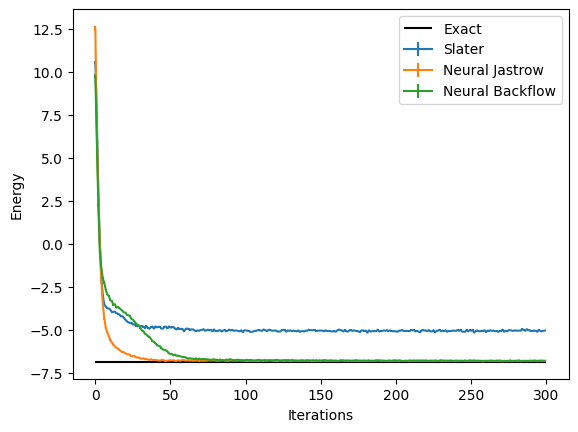

In [27]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

# References

[1] Becca, F. & Sorella, S. Quantum Monte Carlo Approaches for Correlated Systems. (Cambridge University Press, 2017).

[2] Nomura, Y., Darmawan, A. S., Yamaji, Y. & Imada, M. Restricted Boltzmann machine learning for solving strongly correlated quantum systems. Phys. Rev. B 96, 205152 (2017).

[3] Stokes, J., Moreno, J. R., Pnevmatikakis, E. A. & Carleo, G. Phases of two-dimensional spinless lattice fermions with first-quantized deep neural-network quantum states. Phys. Rev. B 102, 205122 (2020).

[4] Luo, D. & Clark, B. K. Backflow Transformations via Neural Networks for Quantum Many-Body Wave Functions. Phys. Rev. Lett. 122, 226401 (2019).

